# Household Accessiblity Analysis
This notebook has been fixed and is valid JSON.

In [136]:
# reading data on google drive
from google.colab import drive
# Mount your Google Drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# Load CSV file from Google Drive
file_path = '/content/drive/MyDrive/other/data/Data for MSC Thesis/eth_householdgeovariables_y5.csv'
df = pd.read_csv(file_path)

print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        household_id  dist_road  dist_market  dist_border  dist_popcenter  \
0  20101010100104011        7.7   162.300003    82.900002             0.4   
1  20101010100104022        7.7   162.300003    82.900002             0.4   
2  20101010100104033        7.7   162.300003    82.900002             0.4   
3  20101010100104044        7.7   162.300003    82.900002             0.4   
4  20101010100104055        7.7   162.300003    82.900002             0.4   

   dist_admhq  af_bio_1_x  af_bio_8_x  af_bio_12_x  af_bio_13_x  ...  \
0         0.0         283         307          184           47  ...   
1         0.0         283         307          184           47  ...   
2         0.0         283         307          184           47  ...   
3         0.0         283         307          184           47  ...   
4         0.0         283         307          1

In [137]:
# ------------------------------
# DATA EXPLORATION: NULL AND OUTLIER PERCENTAGE
# ------------------------------

# ------------------------------
# Step 1: Dataset Overview
# ------------------------------
print("----- Dataset Info -----")
print(df.info())

print("\n----- Dataset Shape -----")
print(df.shape)

print("\n----- Statistical Summary -----")
print(df.describe())

# ------------------------------
# Step 2: Missing Values by Percentage
# ------------------------------
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("\n----- Missing Values Summary -----")
print(missing_df.sort_values(by='Percentage', ascending=False))

# ------------------------------
# Step 3: Outlier Detection by Percentage (Numeric Columns Only)
# ------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

outlier_summary = []
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(df)) * 100

    outlier_summary.append([col, outlier_count, outlier_percent])

outlier_df = pd.DataFrame(outlier_summary, columns=['Column', 'Outlier Count', 'Outlier %'])
print("\n----- Outlier Summary by Percentage -----")
print(outlier_df.sort_values(by='Outlier %', ascending=False))

----- Dataset Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   household_id       4890 non-null   int64  
 1   dist_road          4890 non-null   float64
 2   dist_market        4890 non-null   float64
 3   dist_border        4890 non-null   float64
 4   dist_popcenter     4890 non-null   float64
 5   dist_admhq         4890 non-null   float64
 6   af_bio_1_x         4890 non-null   int64  
 7   af_bio_8_x         4890 non-null   int64  
 8   af_bio_12_x        4890 non-null   int64  
 9   af_bio_13_x        4890 non-null   int64  
 10  af_bio_16_x        4890 non-null   int64  
 11  afmnslp_pct        4890 non-null   int64  
 12  srtm_1k            4890 non-null   int64  
 13  popdensity         4890 non-null   int64  
 14  cropshare          4890 non-null   int64  
 15  sq1                4890 non-null   int64  
 16 

In [138]:
# check number of distinic catagory
for col in ['ssa_aez09', 'landcov']:
    print(f"\nColumn: {col}")
    print("Number of distinct categories:", df[col].nunique())
    print("Categories:", df[col].unique())


Column: ssa_aez09
Number of distinct categories: 7
Categories: ['Tropic-warm/semiarid' 'Tropic-warm/arid' 'Tropic-cool/subhumid'
 'Tropic-cool/semiarid' 'Tropic-cool/humid' 'Tropic-cool/arid'
 'Tropic-warm/subhumid']

Column: landcov
Number of distinct categories: 9
Categories: ['Bare/sparse vegetation' 'Cropland' 'Built-up' 'Shrubs'
 'Herbaceous vegetation' 'Open forest unknown'
 'Closed forest deciduous broad leaf' 'Closed forest evergreen broad leaf'
 'Open forest deciduous broad leaf']


In [139]:
#----------------------------------------
#1 Drop columns with more than 40% missing
#----------------------------------------
missing_threshold = 0.4
cols_to_drop = df.columns[df.isnull().mean() > missing_threshold]

print("Dropping columns:", cols_to_drop.tolist())
df = df.drop(columns=cols_to_drop)

# 2. Remove spatial leakage
df = df.drop(columns=['lat_dd_mod', 'lon_dd_mod'], errors='ignore')

# 3. Winsorize numeric features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    if col not in ['household_id', 'AI_pca1']:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)

Dropping columns: ['c2_eviarea_avg', 'c2_evimax_avg', 'c2_grn_avg', 'c2_sen_avg', 'c2_h2021_eviarea', 'c2_h2021_evimax', 'c2_h2021_grn', 'c2_h2021_sen']


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   household_id       4890 non-null   int64  
 1   dist_road          4890 non-null   float64
 2   dist_market        4890 non-null   float64
 3   dist_border        4890 non-null   float64
 4   dist_popcenter     4890 non-null   float64
 5   dist_admhq         4890 non-null   float64
 6   af_bio_1_x         4890 non-null   int64  
 7   af_bio_8_x         4890 non-null   int64  
 8   af_bio_12_x        4890 non-null   int64  
 9   af_bio_13_x        4890 non-null   int64  
 10  af_bio_16_x        4890 non-null   int64  
 11  afmnslp_pct        4890 non-null   int64  
 12  srtm_1k            4890 non-null   int64  
 13  popdensity         4890 non-null   int64  
 14  cropshare          4890 non-null   int64  
 15  sq1                4890 non-null   int64  
 16  sq2                4890 

In [141]:
# ==============================
# 2. Check columns
# ==============================
print("Before Encoding:")
print(df[['ssa_aez09','landcov']].head())

# ==============================
# 4. One-Hot Encode categorical columns
# ==============================
df_encoded = pd.get_dummies(
    df,
    columns=['ssa_aez09', 'landcov'],
    drop_first=True   # avoids multicollinearity (important for regression)
)

# ==============================
# 5. View results
# ==============================
print("\nAfter Encoding:")
print(df_encoded.head())

print("\nNew columns created:")
new_cols = [col for col in df_encoded.columns if 'ssa_aez09_' in col or 'landcov_' in col]
print(new_cols)

# ==============================
# 6. Check dataset shape
# ==============================
print("\nOriginal shape:", df.shape)
print("Encoded shape:", df_encoded.shape)

# change to boolean to numerical value
#bool_cols = df_encoded.select_dtypes(include='bool').columns
#df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
df=df_encoded.copy()

Before Encoding:
              ssa_aez09                 landcov
0  Tropic-warm/semiarid  Bare/sparse vegetation
1  Tropic-warm/semiarid  Bare/sparse vegetation
2  Tropic-warm/semiarid  Bare/sparse vegetation
3  Tropic-warm/semiarid  Bare/sparse vegetation
4  Tropic-warm/semiarid  Bare/sparse vegetation

After Encoding:
        household_id  dist_road  dist_market  dist_border  dist_popcenter  \
0  20101010100104011        7.7   162.300003    82.900002             0.5   
1  20101010100104022        7.7   162.300003    82.900002             0.5   
2  20101010100104033        7.7   162.300003    82.900002             0.5   
3  20101010100104044        7.7   162.300003    82.900002             0.5   
4  20101010100104055        7.7   162.300003    82.900002             0.5   

   dist_admhq  af_bio_1_x  af_bio_8_x  af_bio_12_x  af_bio_13_x  ...  \
0         0.0         283         307          184           47  ...   
1         0.0         283         307          184           47  ...   

🔧 UPDATED DATA PREPROCESSING WITH ACCESSIBILITY INDEX

1. CREATING ACCESSIBILITY INDEX (TARGET)
--------------------------------------------------
AI_pca1 created ✓  Range: -1.593 to 6.880
Accessibility Classes: {'Low': 1652, 'High': 1628, 'Medium': 1610}
✅ Target variables created successfully!


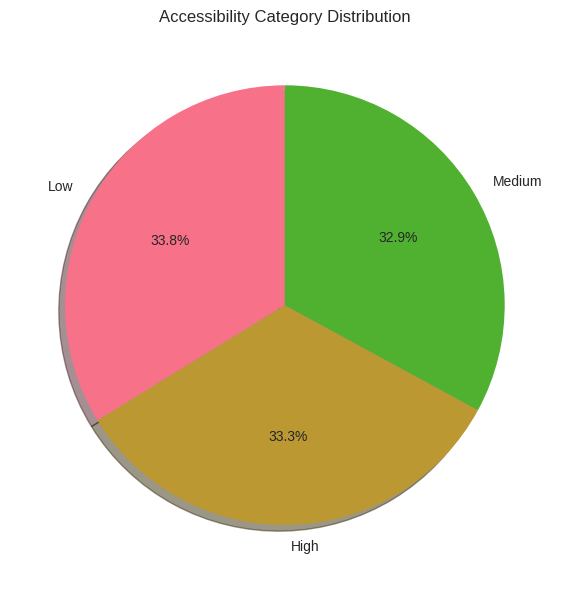

In [142]:
# =============================================================================
# CELL 1: COMPREHENSIVE DATA PREPROCESSING (UPDATED WITH AI + CLASS TARGET)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("🔧 UPDATED DATA PREPROCESSING WITH ACCESSIBILITY INDEX")
print("=" * 60)

# =============================================================================
# 1. CREATE TARGET VARIABLE: ACCESSIBILITY INDEX (TARGET)
# =============================================================================
print("\n1. CREATING ACCESSIBILITY INDEX (TARGET)")
print("-" * 50)

# 5 distance columns (required for AI)
dist_cols = ['dist_road', 'dist_market', 'dist_popcenter',
             'dist_border', 'dist_admhq']

# --- Standardize distance variables ---
scaler_ai = StandardScaler()
Z = scaler_ai.fit_transform(df[dist_cols])

# --- PCA to compute Accessibility Index ---
pca = PCA(n_components=1)
df['AI_pca1'] = pca.fit_transform(Z)[:, 0]  # continuous target

print(f"AI_pca1 created ✓  Range: {df['AI_pca1'].min():.3f} to {df['AI_pca1'].max():.3f}")

# ------------------------------
# Create 3-class Accessibility Category
# ------------------------------
q33 = df['AI_pca1'].quantile(0.33)
q66 = df['AI_pca1'].quantile(0.66)

def classify_access(x):
    if x <= q33:
        return "High"       # best access
    elif x <= q66:
        return "Medium"
    else:
        return "Low"        # worst access

df['accessibility_category'] = df['AI_pca1'].apply(classify_access)

print("Accessibility Classes:", df['accessibility_category'].value_counts().to_dict())
print("✅ Target variables created successfully!")

# =============================================================================
# VISUALIZATION
# =============================================================================

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(7, 6))

# Pie chart of accessibility categories
df['accessibility_category'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    ax=axes,
    startangle=90,
    shadow=True
)

axes.set_ylabel("")  # remove default label
axes.set_title("Accessibility Category Distribution")

plt.tight_layout()
plt.show()

In [143]:
# ------------------------------
# FULL PREPROCESSING PIPELINE WITH SMOTE (NO WARNINGS)
# ------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# ------------------------------
# Step 1: Drop irrelevant/correlated columns
# ------------------------------

cols_to_drop = [
    'household_id',
    'dist_road',
    'dist_market',
    'dist_border',
    'dist_popcenter',
    'dist_admhq','suppress'
]

df = df.drop(columns=cols_to_drop, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   af_bio_1_x                                  4890 non-null   int64  
 1   af_bio_8_x                                  4890 non-null   int64  
 2   af_bio_12_x                                 4890 non-null   int64  
 3   af_bio_13_x                                 4890 non-null   int64  
 4   af_bio_16_x                                 4890 non-null   int64  
 5   afmnslp_pct                                 4890 non-null   int64  
 6   srtm_1k                                     4890 non-null   int64  
 7   popdensity                                  4890 non-null   int64  
 8   cropshare                                   4890 non-null   int64  
 9   sq1                                         4890 non-null   int64  
 10  sq2         


COMPREHENSIVE CORRELATION AND VIF ANALYSIS

1. PREPARING ALL DATA COLUMNS
----------------------------------------
Total numerical columns in df: 19
Including target column: AI_pca1

Analyzing 19 columns total:

2. CORRELATION HEATMAP (WITH VALUES)
----------------------------------------


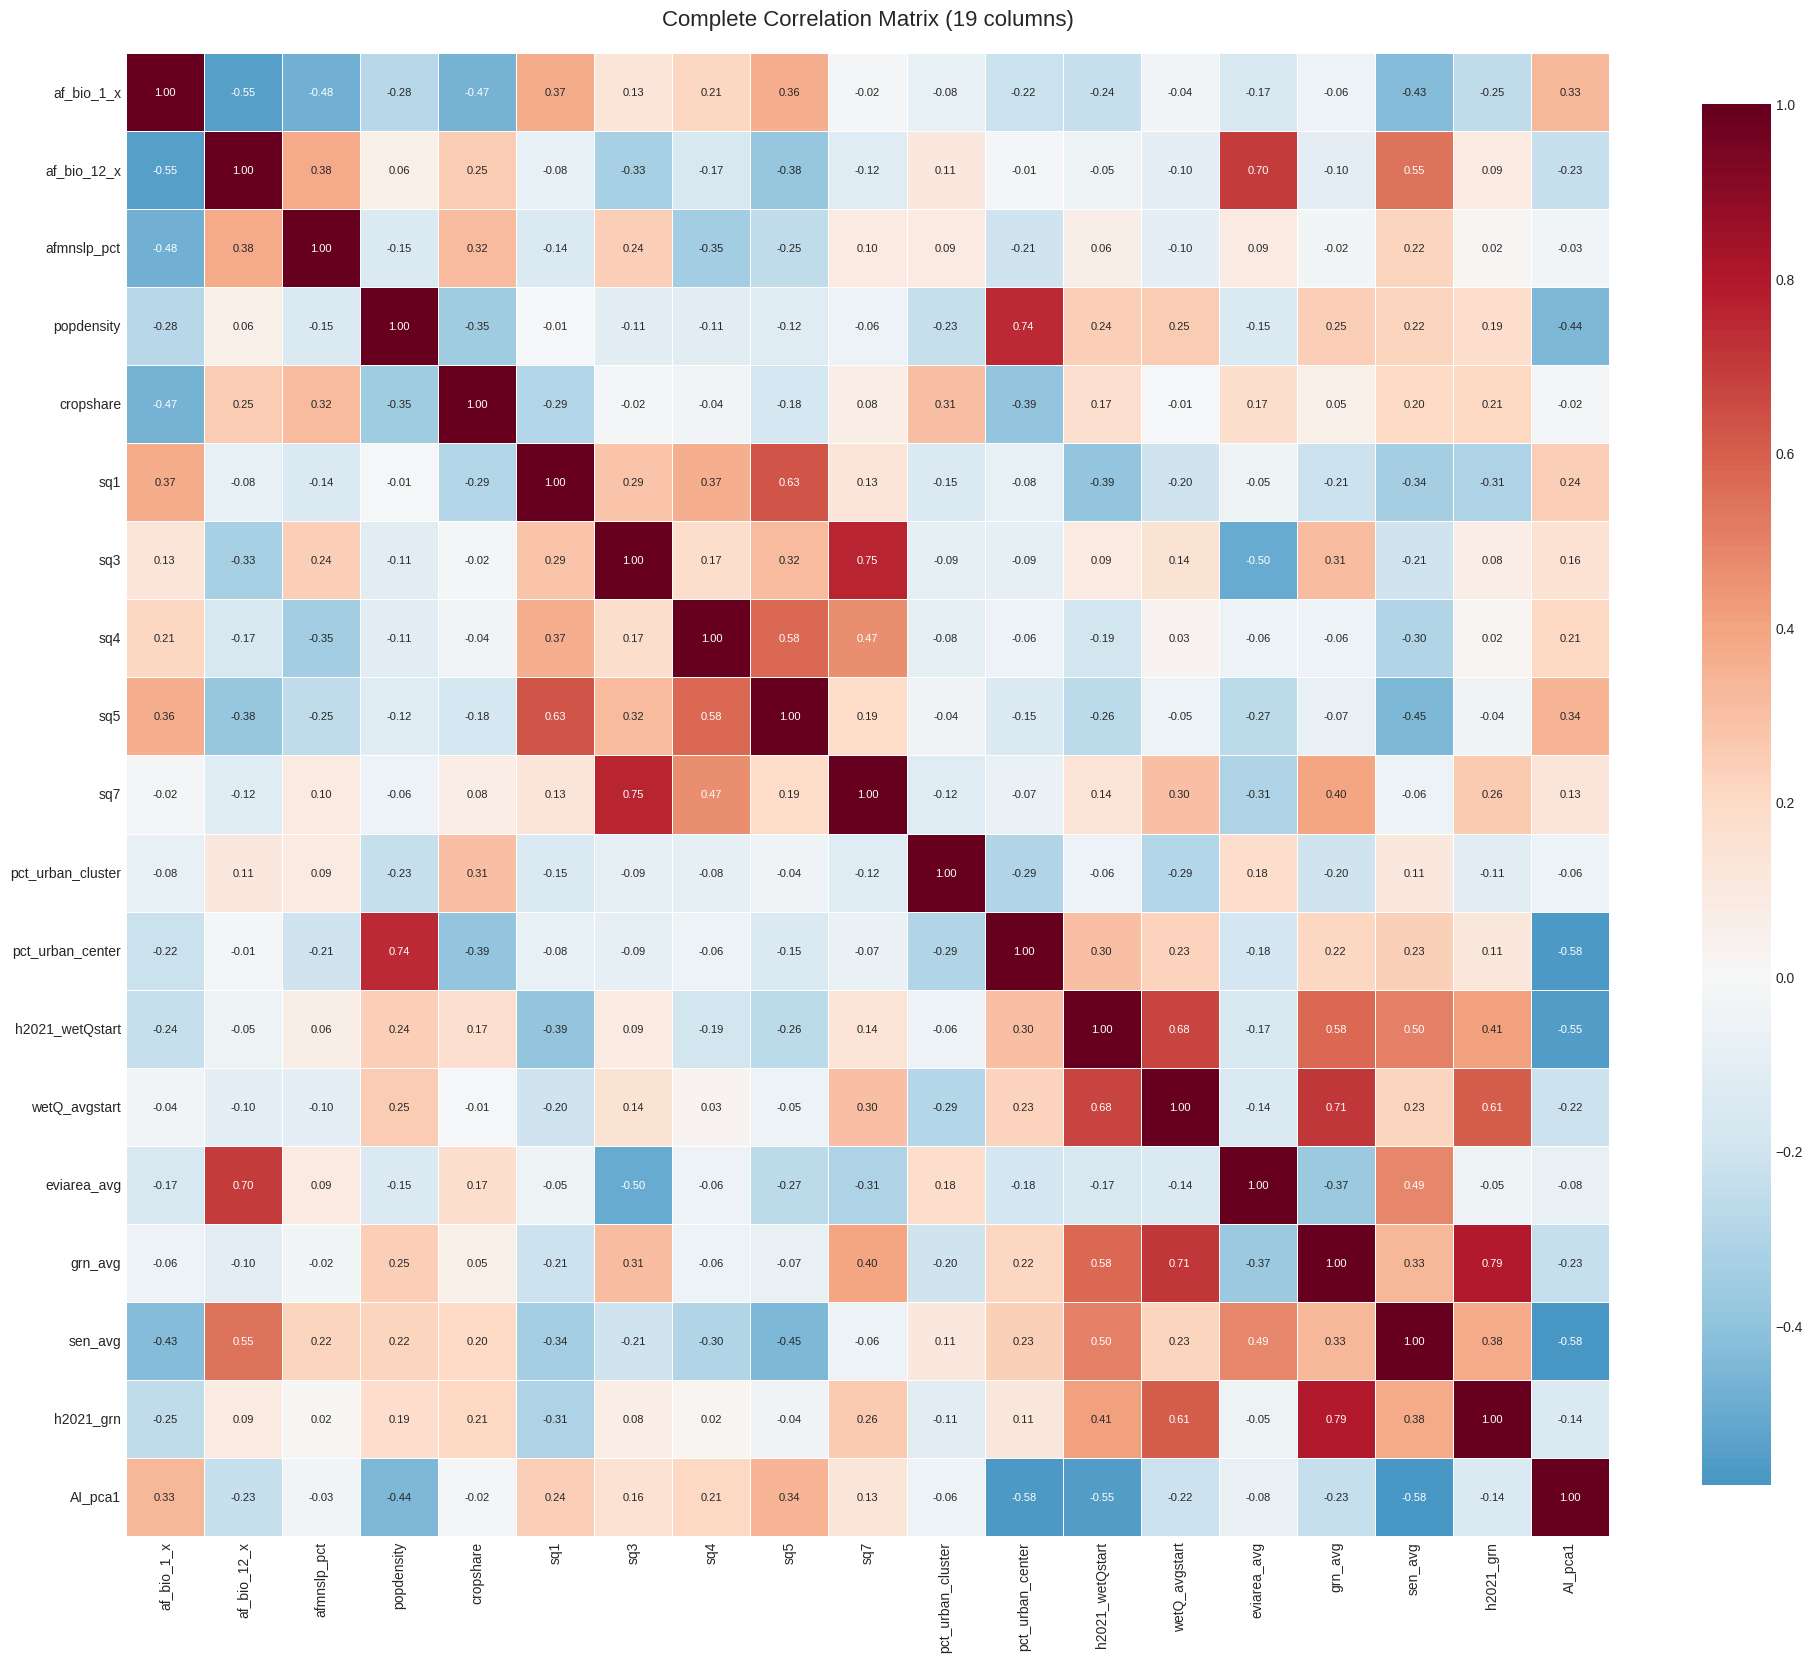


3. TARGET CORRELATION ANALYSIS
----------------------------------------

Top 10 features correlated with AI_pca1:
--------------------------------------------------
 1. sen_avg                        :  -0.583 (negative)
 2. pct_urban_center               :  -0.576 (negative)
 3. h2021_wetQstart                :  -0.553 (negative)
 4. popdensity                     :  -0.443 (negative)
 5. sq5                            :   0.342 (positive)
 6. af_bio_1_x                     :   0.329 (positive)
 7. sq1                            :   0.239 (positive)
 8. grn_avg                        :  -0.233 (negative)
 9. af_bio_12_x                    :  -0.229 (negative)
10. wetQ_avgstart                  :  -0.216 (negative)


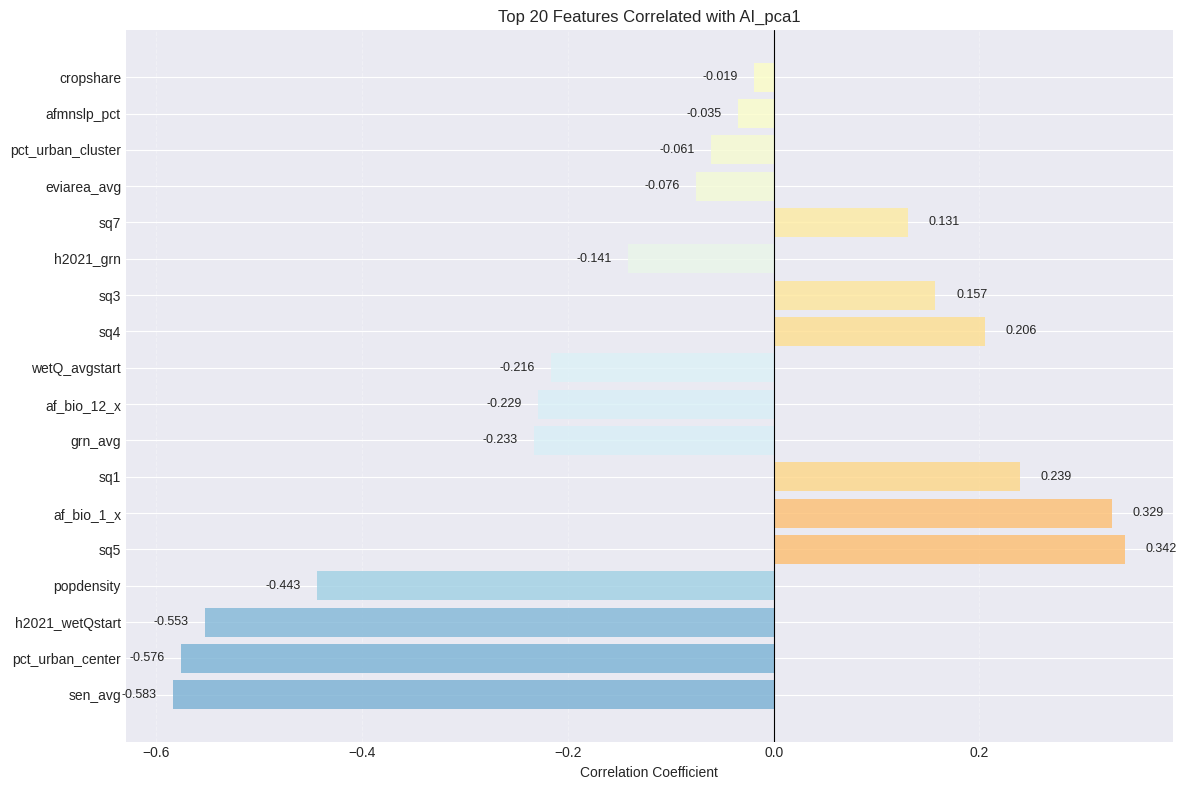


4. VIF ANALYSIS FOR ALL NUMERICAL FEATURES
----------------------------------------
Calculating VIF for 18 features...

VIF RESULTS SUMMARY:
------------------------------------------------------------
Feature                        VIF      Status      
------------------------------------------------------------
🔴 grn_avg                         11.39 HIGH VIF    
🟡 eviarea_avg                      8.55 MODERATE    
🟡 sq7                              6.05 MODERATE    
🟡 sq3                              5.92 MODERATE    
🟡 sen_avg                          5.84 MODERATE    
🟡 h2021_grn                        5.49 MODERATE    
🟢 af_bio_12_x                      4.96 OK          
🟢 wetQ_avgstart                    4.91 OK          
🟢 af_bio_1_x                       4.81 OK          
🟢 h2021_wetQstart                  4.44 OK          
🟢 sq5                              3.50 OK          
🟢 sq4                              3.47 OK          
🟢 pct_urban_center                 3.26 OK     

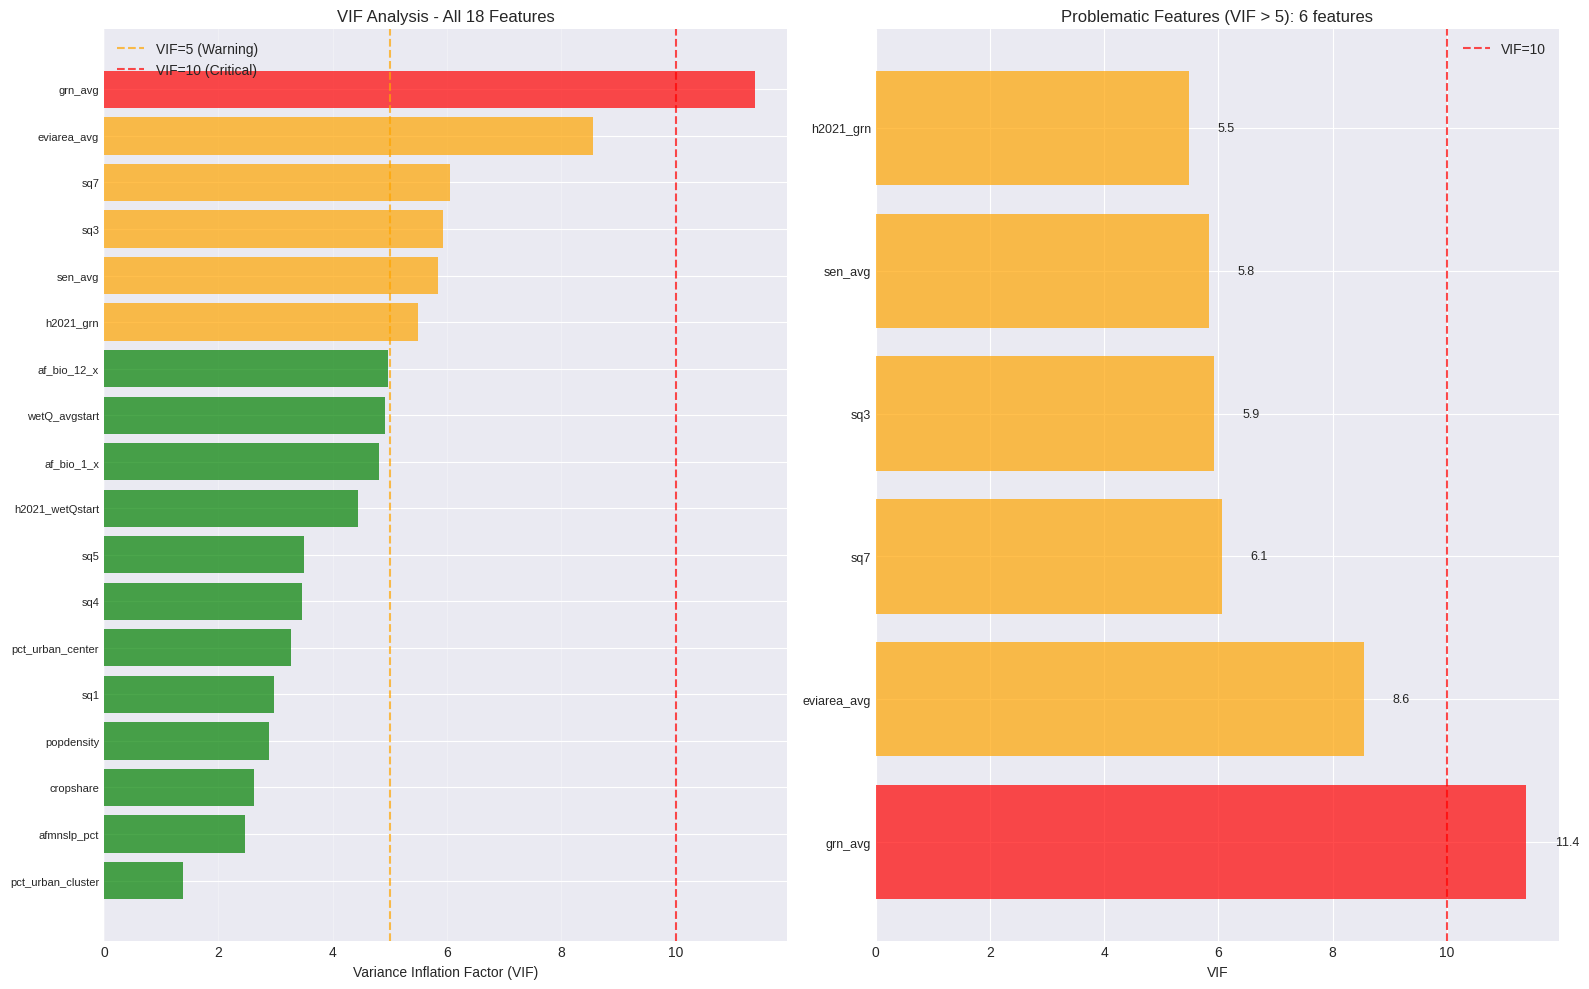


6. HIGHLY CORRELATED FEATURE PAIRS
----------------------------------------
No feature pairs found with |correlation| > 0.8

COMPREHENSIVE ANALYSIS SUMMARY

📊 SUMMARY STATISTICS:
  • Total columns analyzed: 19
  • Features with HIGH VIF (>10): 1
  • Features with MODERATE VIF (5-10): 5
  • Highly correlated pairs (|r| > 0.8): 0
  • Maximum VIF: 11.39
  • Average VIF: 4.72

🎯 TOP FEATURES FOR TARGET PREDICTION:
  • sen_avg: correlation = -0.583, VIF = 5.84
  • pct_urban_center: correlation = -0.576, VIF = 3.26
  • h2021_wetQstart: correlation = -0.553, VIF = 4.44

⚠️  RECOMMENDATIONS:
  1. Consider removing features with VIF > 10:
     - grn_avg (VIF = 11.4)

ANALYSIS COMPLETE

Results stored in 'analysis_results' dictionary


In [147]:
# =============================================================================
# CORRELATION & VIF ANALYSIS - COMPLETE VERSION
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

print("\n" + "="*60)
print("COMPREHENSIVE CORRELATION AND VIF ANALYSIS")
print("="*60)

# =============================================================================
# 1. PREPARE DATA WITH ALL COLUMNS
# =============================================================================
print("\n1. PREPARING ALL DATA COLUMNS")
print("-"*40)

# Get ALL numerical columns from original dataframe
all_numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Total numerical columns in df: {len(all_numerical_cols)}")

# Create DataFrame with ALL numerical columns + target
full_data = df[all_numerical_cols].copy()

# Make sure AI_pca1 is included (it's already in df from your preprocessing)
print(f"Including target column: AI_pca1")

# Display column count
print(f"\nAnalyzing {len(full_data.columns)} columns total:")

# =============================================================================
# 2. COMPREHENSIVE CORRELATION HEATMAP WITH NUMBERS
# =============================================================================
print("\n2. CORRELATION HEATMAP (WITH VALUES)")
print("-"*40)

# Calculate correlation matrix
corr_matrix = full_data.corr()

# Determine figure size based on number of columns
n_cols = len(corr_matrix.columns)
fig_width = max(20, n_cols * 0.7)
fig_height = max(18, n_cols * 0.6)

plt.figure(figsize=(fig_width, fig_height))

# Create heatmap with numbers
sns.heatmap(corr_matrix,
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            annot=True,  # Show numbers
            annot_kws={'size': 8},  # Font size for numbers
            fmt='.2f',  # Format numbers to 2 decimal places
            xticklabels=True,
            yticklabels=True)

plt.title(f'Complete Correlation Matrix ({n_cols} columns)', fontsize=16, pad=20)
plt.xticks(rotation=90, ha='center')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# =============================================================================
# 3. TARGET-SPECIFIC CORRELATION ANALYSIS
# =============================================================================
print("\n3. TARGET CORRELATION ANALYSIS")
print("-"*40)

# Find correlations with AI_pca1
if 'AI_pca1' in corr_matrix.columns:
    target_corrs = corr_matrix['AI_pca1'].drop('AI_pca1').sort_values(key=abs, ascending=False)

    print(f"\nTop 10 features correlated with AI_pca1:")
    print("-"*50)
    for i, (feat, corr) in enumerate(target_corrs.head(10).items(), 1):
        direction = "positive" if corr > 0 else "negative"
        print(f"{i:2}. {feat:30} : {corr:7.3f} ({direction})")

    # Plot top correlations
    plt.figure(figsize=(12, 8))
    top_20 = target_corrs.head(20)

    # Create color gradient
    colors = plt.cm.RdYlBu_r((top_20.values + 1) / 2)

    bars = plt.barh(range(len(top_20)), top_20.values, color=colors, alpha=0.8)
    plt.yticks(range(len(top_20)), top_20.index)
    plt.axvline(x=0, color='black', linewidth=0.8)
    plt.xlabel('Correlation Coefficient')
    plt.title('Top 20 Features Correlated with AI_pca1')
    plt.grid(axis='x', alpha=0.3, linestyle='--')

    # Add correlation values on bars
    for i, (bar, val) in enumerate(zip(bars, top_20.values)):
        x_pos = val + (0.02 if val >= 0 else -0.05)
        plt.text(x_pos, i, f'{val:.3f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 4. VIF ANALYSIS FOR ALL NUMERICAL FEATURES
# =============================================================================
print("\n4. VIF ANALYSIS FOR ALL NUMERICAL FEATURES")
print("-"*40)

# Remove target column for VIF calculation (if present)
features_for_vif = [col for col in full_data.columns if col != 'AI_pca1']
X_for_vif = full_data[features_for_vif].copy()

print(f"Calculating VIF for {len(X_for_vif.columns)} features...")

# Calculate VIF
def calculate_vif_safe(X_df, max_features=50):
    """Calculate VIF safely handling large datasets"""
    if len(X_df.columns) > max_features:
        print(f"  Note: Calculating VIF for {len(X_df.columns)} features may take time...")

    X_const = add_constant(X_df)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_const.columns

    vif_values = []
    for i in range(X_const.shape[1]):
        try:
            vif = variance_inflation_factor(X_const.values, i)
            vif_values.append(vif)
        except:
            vif_values.append(np.nan)

    vif_data["VIF"] = vif_values
    vif_data = vif_data[vif_data['feature'] != 'const']
    return vif_data.sort_values('VIF', ascending=False)

vif_results = calculate_vif_safe(X_for_vif)

print(f"\nVIF RESULTS SUMMARY:")
print("-"*60)
print(f"{'Feature':30} {'VIF':8} {'Status':12}")
print("-"*60)

# Display results with categorization
for _, row in vif_results.iterrows():
    vif_val = row['VIF']
    if pd.isna(vif_val):
        status = "ERROR"
        symbol = "❌"
    elif vif_val > 10:
        status = "HIGH VIF"
        symbol = "🔴"
    elif vif_val > 5:
        status = "MODERATE"
        symbol = "🟡"
    else:
        status = "OK"
        symbol = "🟢"

    print(f"{symbol} {row['feature']:28} {vif_val:8.2f} {status:12}")

# =============================================================================
# 5. VIF VISUALIZATION
# =============================================================================
print("\n5. VIF VISUALIZATION")
print("-"*40)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Plot 1: All VIF values
vif_sorted = vif_results.sort_values('VIF')
axes[0].barh(range(len(vif_sorted)), vif_sorted['VIF'],
             color=['red' if v > 10 else 'orange' if v > 5 else 'green'
                    for v in vif_sorted['VIF']],
             alpha=0.7)
axes[0].set_yticks(range(len(vif_sorted)))
axes[0].set_yticklabels(vif_sorted['feature'], fontsize=8)
axes[0].axvline(x=5, color='orange', linestyle='--', alpha=0.7, label='VIF=5 (Warning)')
axes[0].axvline(x=10, color='red', linestyle='--', alpha=0.7, label='VIF=10 (Critical)')
axes[0].set_xlabel('Variance Inflation Factor (VIF)')
axes[0].set_title(f'VIF Analysis - All {len(vif_sorted)} Features')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Problematic features only
problematic = vif_results[vif_results['VIF'] > 5]
if len(problematic) > 0:
    axes[1].barh(range(len(problematic)), problematic['VIF'],
                 color=['red' if v > 10 else 'orange' for v in problematic['VIF']],
                 alpha=0.7)
    axes[1].set_yticks(range(len(problematic)))
    axes[1].set_yticklabels(problematic['feature'], fontsize=9)
    axes[1].axvline(x=10, color='red', linestyle='--', alpha=0.7, label='VIF=10')
    axes[1].set_xlabel('VIF')
    axes[1].set_title(f'Problematic Features (VIF > 5): {len(problematic)} features')
    axes[1].legend()

    # Add VIF values on bars
    for i, (_, row) in enumerate(problematic.iterrows()):
        axes[1].text(row['VIF'] + 0.5, i, f'{row["VIF"]:.1f}',
                    va='center', fontsize=9)
else:
    axes[1].text(0.5, 0.5, 'No VIF issues!\nAll features have VIF < 5',
                ha='center', va='center', transform=axes[1].transAxes,
                fontsize=14, color='green')
    axes[1].set_title('No Multicollinearity Issues')

plt.tight_layout()
plt.show()

# =============================================================================
# 6. HIGHLY CORRELATED FEATURE PAIRS
# =============================================================================
print("\n6. HIGHLY CORRELATED FEATURE PAIRS")
print("-"*40)

threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            feat1, feat2 = corr_matrix.columns[i], corr_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_val))

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} pairs with |correlation| > {threshold}:")
    print("-"*80)
    print(f"{'Feature 1':30} {'Feature 2':30} {'Correlation':12}")
    print("-"*80)

    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"{feat1:30} {feat2:30} {corr:12.3f}")
else:
    print(f"No feature pairs found with |correlation| > {threshold}")

# =============================================================================
# 7. COMPREHENSIVE SUMMARY
# =============================================================================
print("\n" + "="*60)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*60)

# Summary statistics
high_vif = vif_results[vif_results['VIF'] > 10]
moderate_vif = vif_results[(vif_results['VIF'] > 5) & (vif_results['VIF'] <= 10)]

print(f"\n📊 SUMMARY STATISTICS:")
print(f"  • Total columns analyzed: {len(full_data.columns)}")
print(f"  • Features with HIGH VIF (>10): {len(high_vif)}")
print(f"  • Features with MODERATE VIF (5-10): {len(moderate_vif)}")
print(f"  • Highly correlated pairs (|r| > 0.8): {len(high_corr_pairs)}")
print(f"  • Maximum VIF: {vif_results['VIF'].max():.2f}")
print(f"  • Average VIF: {vif_results['VIF'].mean():.2f}")

# Top correlations with target
if 'AI_pca1' in corr_matrix.columns:
    top_target_corr = target_corrs.head(3)
    print(f"\n🎯 TOP FEATURES FOR TARGET PREDICTION:")
    for feat, corr in top_target_corr.items():
        vif_val = vif_results[vif_results['feature'] == feat]['VIF'].values[0] if feat in vif_results['feature'].values else np.nan
        print(f"  • {feat}: correlation = {corr:.3f}, VIF = {vif_val:.2f}")

# Recommendations
print(f"\n⚠️  RECOMMENDATIONS:")
if len(high_vif) > 0:
    print(f"  1. Consider removing features with VIF > 10:")
    for _, row in high_vif.head(5).iterrows():
        print(f"     - {row['feature']} (VIF = {row['VIF']:.1f})")
if len(high_corr_pairs) > 0:
    print(f"  2. Check these highly correlated pairs for redundancy")
if len(high_vif) == 0 and len(high_corr_pairs) == 0:
    print("  ✓ No major multicollinearity issues detected!")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

# Store results for later use
analysis_results = {
    'correlation_matrix': corr_matrix,
    'vif_results': vif_results,
    'high_correlation_pairs': high_corr_pairs,
    'target_correlations': target_corrs if 'AI_pca1' in corr_matrix.columns else None
}

print("\nResults stored in 'analysis_results' dictionary")

In [146]:
to_drop = [
    'h2021_evimax', 'h2021_eviarea', 'h2021_tot', 'h2021_wetQ',
    'af_bio_8_x', 'af_bio_13_x', 'af_bio_16_x',
    'sq2', 'sq6','srtm_1k',
    'h2021_sen',
    'evimax_avg',
    'wetQ_avg',       # or anntot_avg — pick one
    'twi_ne','anntot_avg'
]

df_reduced = df.drop(columns=to_drop)
df=df_reduced.copy()


KeyError: "['h2021_evimax', 'h2021_eviarea', 'h2021_tot', 'h2021_wetQ', 'af_bio_8_x', 'af_bio_13_x', 'af_bio_16_x', 'sq2', 'sq6', 'srtm_1k', 'h2021_sen', 'evimax_avg', 'wetQ_avg', 'twi_ne', 'anntot_avg'] not found in axis"

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   af_bio_1_x                                  4890 non-null   int64  
 1   af_bio_12_x                                 4890 non-null   int64  
 2   afmnslp_pct                                 4890 non-null   int64  
 3   popdensity                                  4890 non-null   int64  
 4   cropshare                                   4890 non-null   int64  
 5   sq1                                         4890 non-null   int64  
 6   sq3                                         4890 non-null   int64  
 7   sq4                                         4890 non-null   int64  
 8   sq5                                         4890 non-null   int64  
 9   sq7                                         4890 non-null   int64  
 10  pct_urban_cl

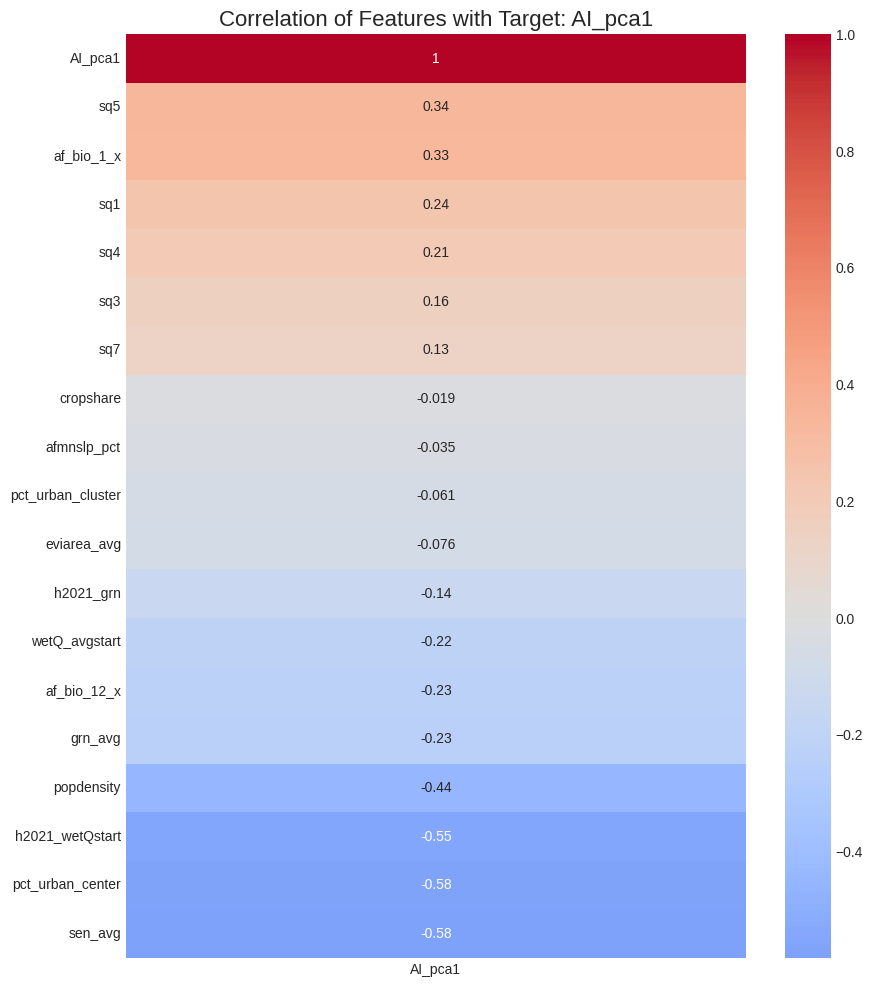

In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your dataset with renamed columns

# Step 1: Choose target column
target = 'AI_pca1'

# Step 2: Select numeric columns only
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Step 3: Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Step 4: Focus on correlations with target
target_corr = corr_matrix[[target]].sort_values(by=target, ascending=False)

# Step 5: Plot heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0)
plt.title(f'Correlation of Features with Target: {target}', fontsize=16)
plt.show()

In [152]:
# ===============================
# Define targets
# ===============================
y_reg = df['AI_pca1']                     # regression
y_cls = df['accessibility_category']      # classification

# ===============================
# Define features (remove targets)
# ===============================
X = df.drop(columns=['AI_pca1','accessibility_category'])

bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

In [153]:
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=0.95)  # retain 95% variance
X_reduced = pca.fit_transform(X_scaled)

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

scaler = StandardScaler()

X_train_r = scaler.fit_transform(X_train_r)
X_test_r  = scaler.transform(X_test_r)

In [155]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

rf_reg = RandomForestRegressor(n_estimators=300, random_state=42)
rf_reg.fit(X_train_r, y_train_r)

pred_r = rf_reg.predict(X_test_r)

print("R2:", r2_score(y_test_r, pred_r))
print("MAE:", mean_absolute_error(y_test_r, pred_r))
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, pred_r)))

R2: 0.9990024831452399
MAE: 0.006167752685718793
RMSE: 0.05072093500038394


Training LinearRegression...
  Test RMSE: 0.8927 | Test R²: 0.6910
Training Ridge(alpha=1.0)...
  Test RMSE: 0.8928 | Test R²: 0.6909
Training RandomForest...
  Test RMSE: 0.0530 | Test R²: 0.9989
Training XGBoost...
  Test RMSE: 0.0586 | Test R²: 0.9987
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1208
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 30
[LightGBM] [Info] Start training from score -0.017199
  Test RMSE: 0.0577 | Test R²: 0.9987

PERFORMANCE SUMMARY (Sorted by Test RMSE)


,Model,RMSE_Train,RMSE_Test,R²_Train,R²_Test,Overfit_Gap
2,RandomForest,0.033125,0.053016,0.999561,0.998910,-0.019891
4,LightGBM,0.018163,0.057677,0.999868,0.998710,-0.039514
3,XGBoost,0.032237,0.058556,0.999584,0.998671,-0.026319
0,LinearRegression,0.850619,0.892656,0.710243,0.691032,-0.042037
1,Ridge(alpha=1.0),0.850693,0.892843,0.710192,0.690902,-0.042150


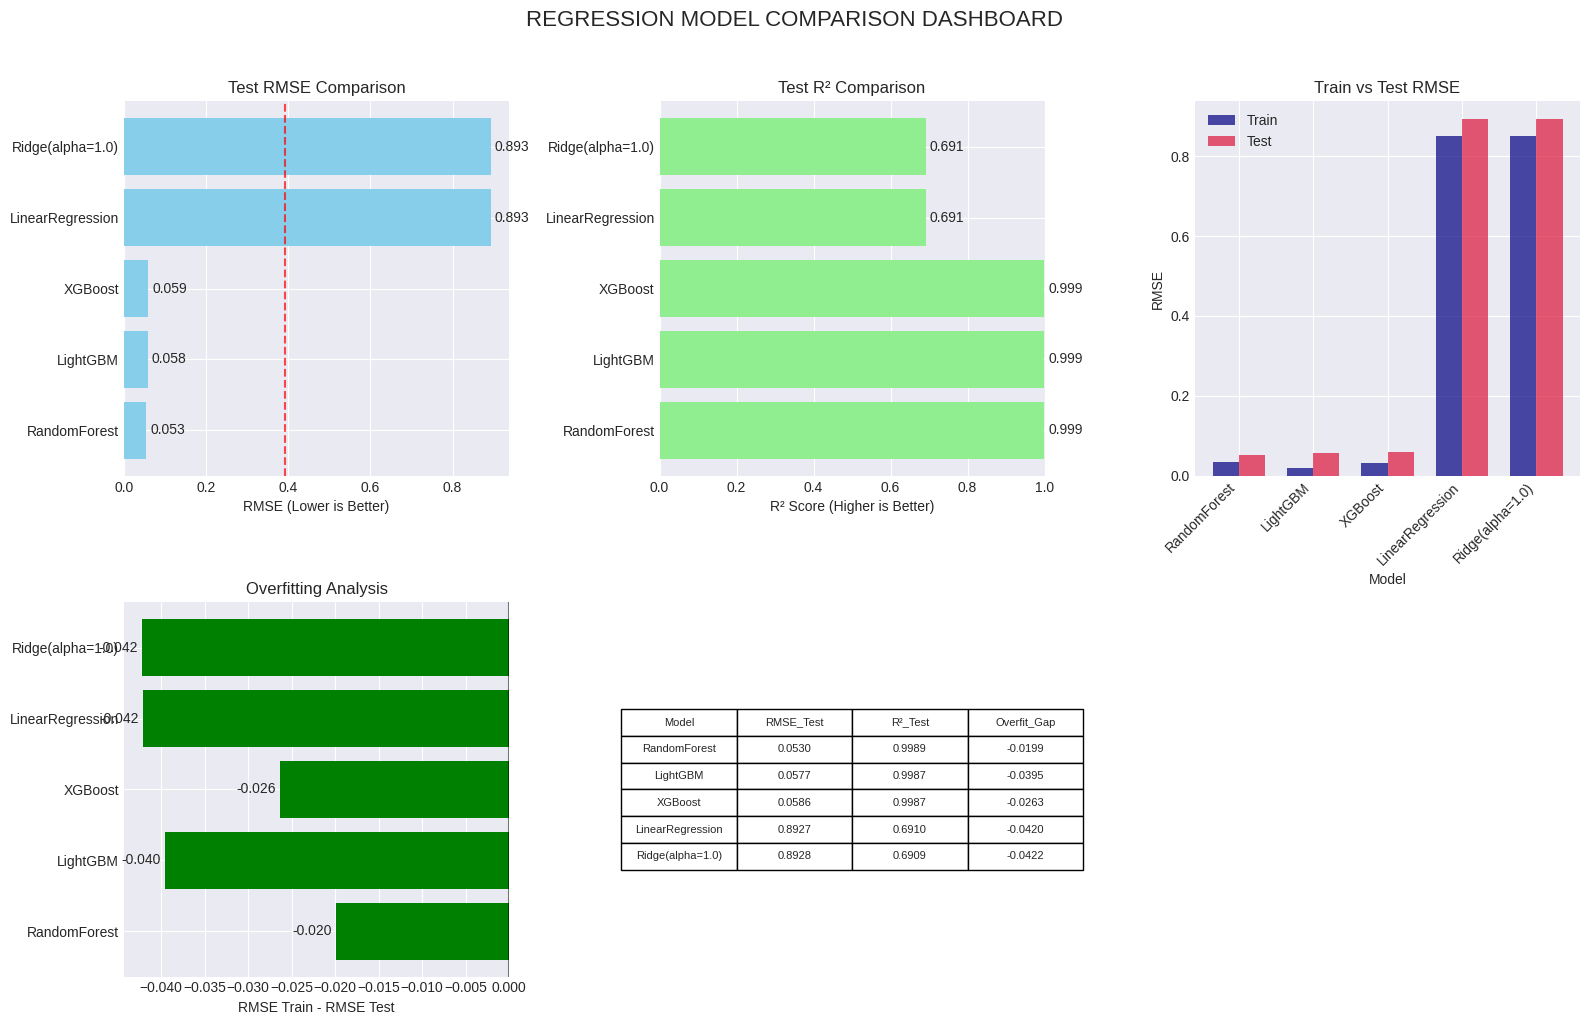

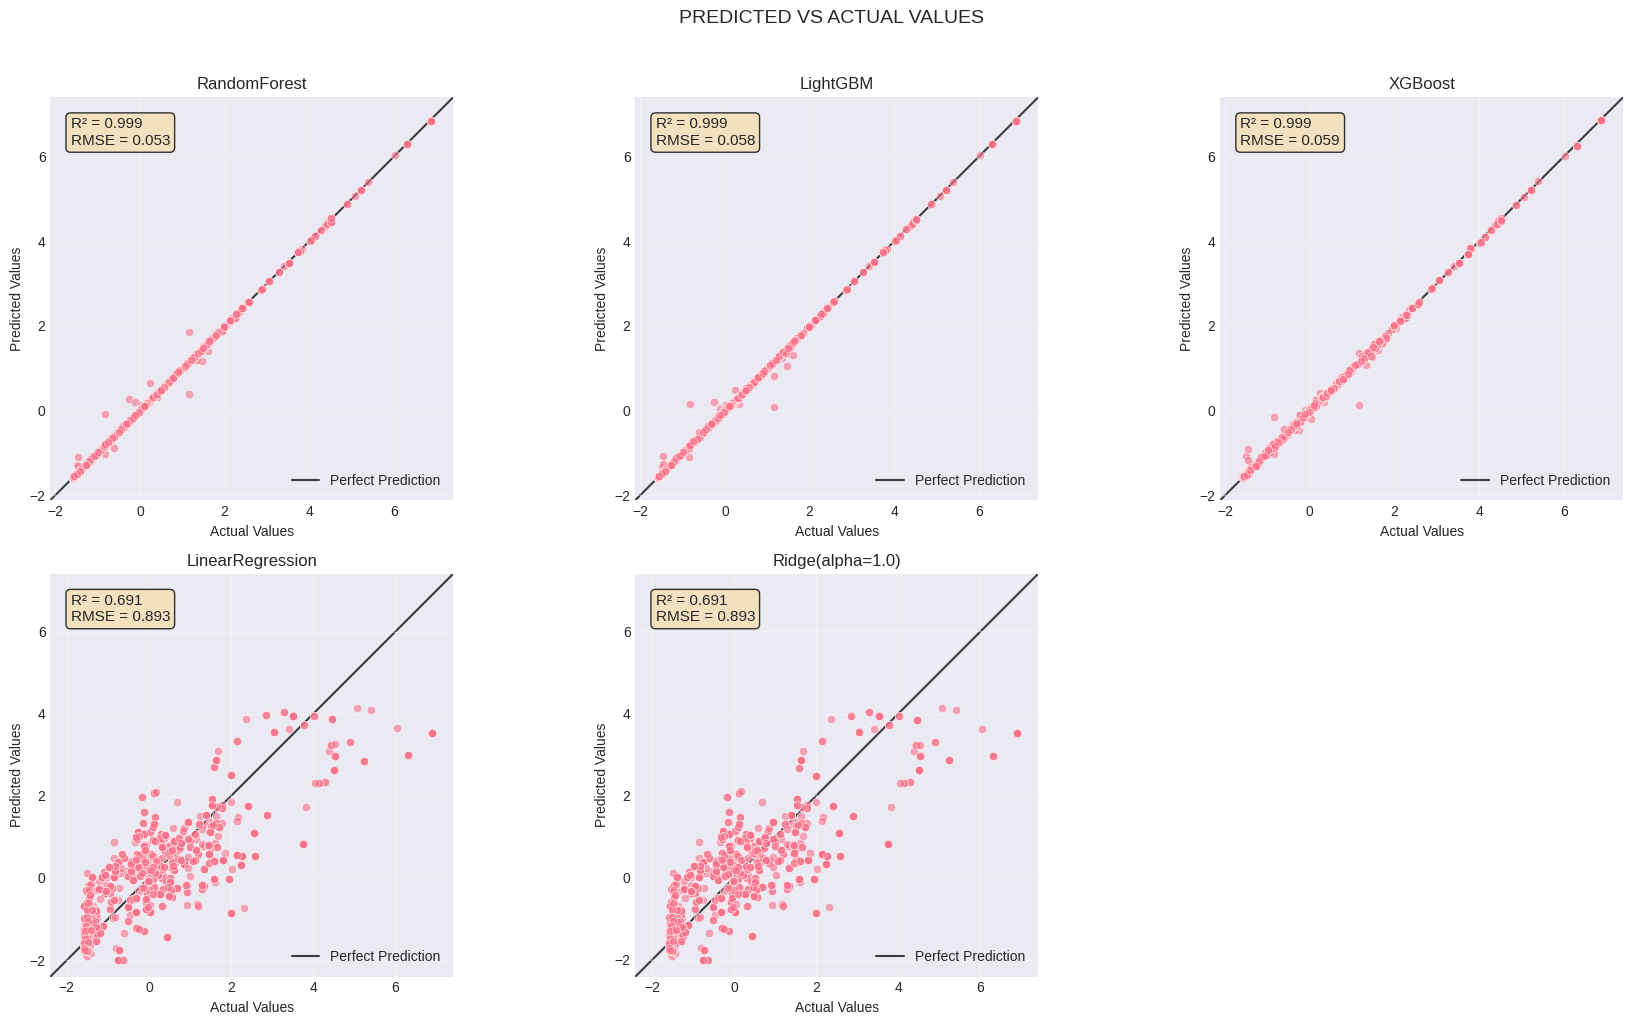


FEATURE IMPORTANCE ANALYSIS (Best Model: RandomForest)


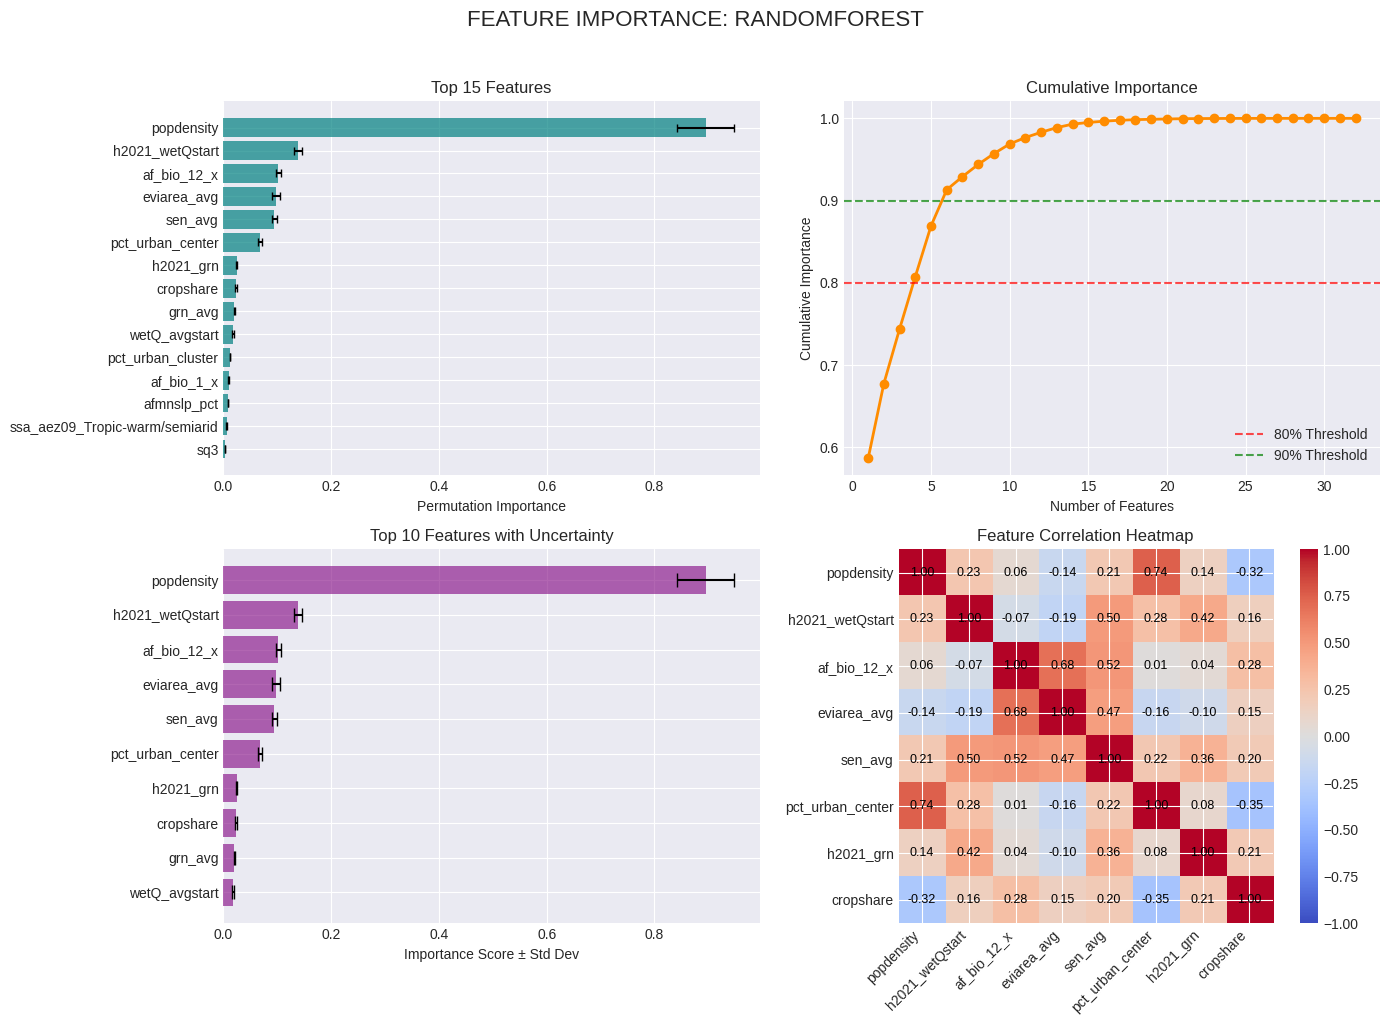


Top 10 Most Important Features:


,feature,importance_mean,importance_std
0,popdensity,0.895272,0.052727
1,h2021_wetQstart,0.139041,0.007417
2,af_bio_12_x,0.101332,0.004524
3,eviarea_avg,0.097161,0.007983
4,sen_avg,0.094062,0.004797
5,pct_urban_center,0.067070,0.003590
6,h2021_grn,0.024272,0.001474
7,cropshare,0.022566,0.001874
8,grn_avg,0.020148,0.001343
9,wetQ_avgstart,0.017801,0.001509


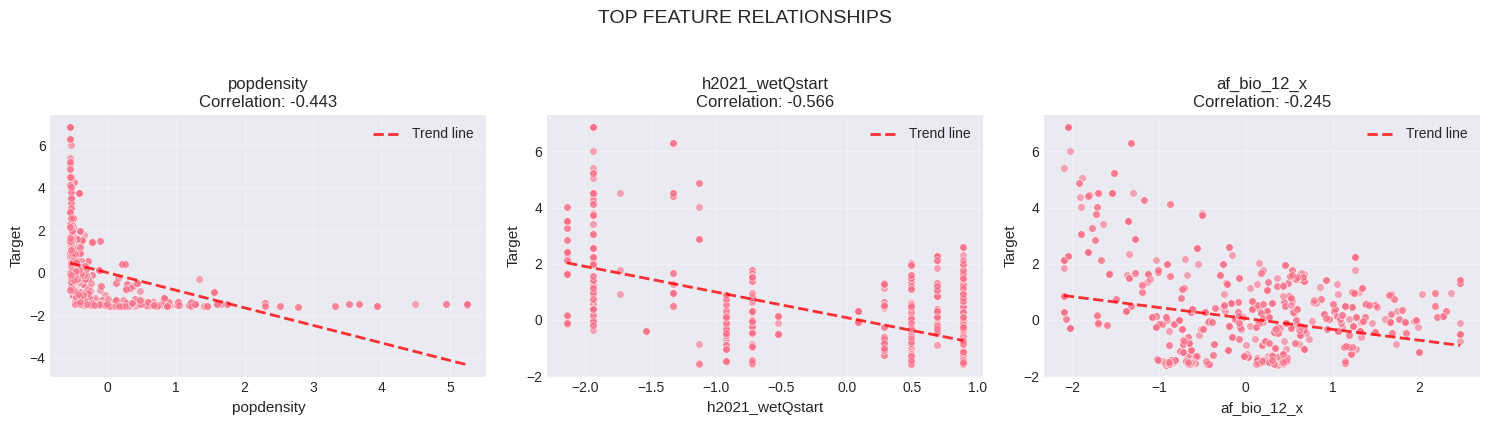

In [156]:
# ============================================================================
# IMPORTS
# ============================================================================
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Optional model imports (XGBoost / LightGBM).
# These need to be imported within this cell's scope.
try:
    from xgboost import XGBRegressor
    xgb_available = True
except Exception:
    xgb_available = False

try:
    from lightgbm import LGBMRegressor
    lgb_available = True
except Exception:
    lgb_available = False

# Set visual style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# MODEL DEFINITION
# ============================================================================
def define_regression_models(xgb_available=True, lgb_available=True):
    models = {
        "LinearRegression": LinearRegression(),
        "Ridge(alpha=1.0)": Ridge(alpha=1.0),
        "RandomForest": RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
            min_samples_split=5,
            min_samples_leaf=2
        )
    }

    if xgb_available:
        models["XGBoost"] = XGBRegressor(
            n_estimators=200,
            random_state=42,
            verbosity=0,
            n_jobs=1,
            learning_rate=0.1,
            max_depth=5
        )
    if lgb_available:
        models["LightGBM"] = LGBMRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
            learning_rate=0.1,
            num_leaves=31
        )

    return models

# ============================================================================
# MODEL TRAINING AND EVALUATION
# ============================================================================
def train_and_evaluate_models(models, X_train_r, X_test_r, y_train_r, y_test_r):
    results = []
    fitted_models = {}
    predictions = {}

    for name, model in models.items():
        print(f"Training {name}...")

        # Train model
        model.fit(X_train_r, y_train_r)

        # Make predictions
        y_pred_train = model.predict(X_train_r)
        y_pred_test = model.predict(X_test_r)
        predictions[name] = y_pred_test

        # Calculate metrics
        rmse_train = math.sqrt(mean_squared_error(y_train_r, y_pred_train))
        rmse_test = math.sqrt(mean_squared_error(y_test_r, y_pred_test))
        r2_train = r2_score(y_train_r, y_pred_train)
        r2_test = r2_score(y_test_r, y_pred_test)
        overfit_gap = rmse_train - rmse_test

        # Store results
        results.append({
            "Model": name,
            "RMSE_Train": rmse_train,
            "RMSE_Test": rmse_test,
            "R²_Train": r2_train,
            "R²_Test": r2_test,
            "Overfit_Gap": overfit_gap
        })

        fitted_models[name] = model

        print(f"  Test RMSE: {rmse_test:.4f} | Test R²: {r2_test:.4f}")

    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values("RMSE_Test")

    return results_df, fitted_models, predictions

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================
def plot_model_comparison(results_df):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))

    # 1. Test RMSE
    bars = axes[0, 0].barh(results_df['Model'], results_df['RMSE_Test'], color='skyblue')
    axes[0, 0].bar_label(bars, fmt='%.3f', padding=3)
    axes[0, 0].set_xlabel('RMSE (Lower is Better)')
    axes[0, 0].set_title('Test RMSE Comparison')
    axes[0, 0].axvline(results_df['RMSE_Test'].mean(), color='red', linestyle='--', alpha=0.7)

    # 2. Test R²
    bars = axes[0, 1].barh(results_df['Model'], results_df['R²_Test'], color='lightgreen')
    axes[0, 1].bar_label(bars, fmt='%.3f', padding=3)
    axes[0, 1].set_xlabel('R² Score (Higher is Better)')
    axes[0, 1].set_title('Test R² Comparison')
    axes[0, 1].set_xlim([0, 1])

    # 3. Train vs Test RMSE
    x = np.arange(len(results_df))
    width = 0.35
    axes[0, 2].bar(x - width/2, results_df['RMSE_Train'], width, label='Train', color='navy', alpha=0.7)
    axes[0, 2].bar(x + width/2, results_df['RMSE_Test'], width, label='Test', color='crimson', alpha=0.7)
    axes[0, 2].set_xlabel('Model')
    axes[0, 2].set_ylabel('RMSE')
    axes[0, 2].set_title('Train vs Test RMSE')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[0, 2].legend()

    # 4. Overfitting Analysis
    colors = ['green' if gap < 0 else 'red' for gap in results_df['Overfit_Gap']]
    bars = axes[1, 0].barh(results_df['Model'], results_df['Overfit_Gap'], color=colors)
    axes[1, 0].set_xlabel('RMSE Train - RMSE Test')
    axes[1, 0].set_title('Overfitting Analysis')
    axes[1, 0].axvline(0, color='black', linestyle='-', alpha=0.5)
    axes[1, 0].bar_label(bars, fmt='%.3f', padding=3)

    # 5. Performance Summary Table
    axes[1, 1].axis('tight')
    axes[1, 1].axis('off')
    table_data = results_df[['Model', 'RMSE_Test', 'R²_Test', 'Overfit_Gap']].copy()
    table_data['RMSE_Test'] = table_data['RMSE_Test'].map('{:.4f}'.format)
    table_data['R²_Test'] = table_data['R²_Test'].map('{:.4f}'.format)
    table_data['Overfit_Gap'] = table_data['Overfit_Gap'].map('{:.4f}'.format)

    table = axes[1, 1].table(cellText=table_data.values,
                           colLabels=table_data.columns,
                           cellLoc='center',
                           loc='center')
    table.scale(1.2, 1.5)

    # Hide empty subplot
    axes[1, 2].axis('off')

    plt.suptitle('REGRESSION MODEL COMPARISON DASHBOARD', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_prediction_vs_actual(y_test, predictions, model_names, results_df):
    n_models = len(model_names)
    n_cols = min(3, n_models)
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))

    if n_models == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, (model_name, ax) in enumerate(zip(model_names, axes)):
        y_pred = predictions[model_name]
        r2 = results_df[results_df['Model'] == model_name]['R²_Test'].values[0]
        rmse = results_df[results_df['Model'] == model_name]['RMSE_Test'].values[0]

        ax.scatter(y_test, y_pred, alpha=0.6, edgecolors='w', linewidth=0.5)

        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()])-0.1,
            np.max([ax.get_xlim(), ax.get_ylim()])+0.1
        ]
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label='Perfect Prediction')
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

        ax.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.3f}',
                transform=ax.transAxes,
                fontsize=11,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'{model_name}', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)

    for idx in range(len(model_names), len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle('PREDICTED VS ACTUAL VALUES', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(best_model, best_name, X_test, y_test, n_features=15):
    perm = permutation_importance(
        best_model,
        X_test,
        y_test,
        n_repeats=20,
        random_state=42,
        n_jobs=-1
    )

    sorted_idx = perm.importances_mean.argsort()[::-1]

    fi_df = pd.DataFrame({
        'feature': X_test.columns[sorted_idx],
        'importance_mean': perm.importances_mean[sorted_idx],
        'importance_std': perm.importances_std[sorted_idx]
    })

    # Create feature importance visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Top N features bar plot
    top_n = min(n_features, len(fi_df))
    axes[0, 0].barh(range(top_n),
                    fi_df['importance_mean'].head(top_n)[::-1],
                    xerr=fi_df['importance_std'].head(top_n)[::-1],
                    color='teal',
                    alpha=0.7,
                    capsize=3)
    axes[0, 0].set_yticks(range(top_n))
    axes[0, 0].set_yticklabels(fi_df['feature'].head(top_n)[::-1])
    axes[0, 0].set_xlabel('Permutation Importance')
    axes[0, 0].set_title(f'Top {top_n} Features')

    # 2. Cumulative importance
    cumulative_importance = np.cumsum(fi_df['importance_mean']) / np.sum(fi_df['importance_mean'])
    axes[0, 1].plot(range(1, len(cumulative_importance) + 1), cumulative_importance,
                   marker='o', linestyle='-', color='darkorange', linewidth=2)
    axes[0, 1].axhline(0.8, color='red', linestyle='--', alpha=0.7, label='80% Threshold')
    axes[0, 1].axhline(0.9, color='green', linestyle='--', alpha=0.7, label='90% Threshold')
    axes[0, 1].set_xlabel('Number of Features')
    axes[0, 1].set_ylabel('Cumulative Importance')
    axes[0, 1].set_title('Cumulative Importance')
    axes[0, 1].legend()

    # 3. Feature importance with error bars
    features_plot = fi_df.head(10)
    y_pos = np.arange(len(features_plot))
    axes[1, 0].barh(y_pos, features_plot['importance_mean'],
                   xerr=features_plot['importance_std'],
                   color='purple', alpha=0.6, capsize=5)
    axes[1, 0].set_yticks(y_pos)
    axes[1, 0].set_yticklabels(features_plot['feature'])
    axes[1, 0].set_xlabel('Importance Score ± Std Dev')
    axes[1, 0].set_title('Top 10 Features with Uncertainty')
    axes[1, 0].invert_yaxis()

    # 4. Correlation heatmap of top features
    top_features = fi_df['feature'].head(8).tolist()
    if len(top_features) > 1:
        correlation_matrix = X_test[top_features].corr()
        im = axes[1, 1].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        axes[1, 1].set_xticks(np.arange(len(top_features)))
        axes[1, 1].set_yticks(np.arange(len(top_features)))
        axes[1, 1].set_xticklabels(top_features, rotation=45, ha='right')
        axes[1, 1].set_yticklabels(top_features)

        for i in range(len(top_features)):
            for j in range(len(top_features)):
                axes[1, 1].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                               ha='center', va='center', color='black', fontsize=9)

        axes[1, 1].set_title('Feature Correlation Heatmap')
        plt.colorbar(im, ax=axes[1, 1])
    else:
        axes[1, 1].text(0.5, 0.5, 'Need at least 2 features\nfor correlation heatmap',
                       ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Feature Correlation Heatmap')
        axes[1, 1].axis('off')

    plt.suptitle(f'FEATURE IMPORTANCE: {best_name.upper()}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    return fi_df

def plot_feature_relationships(fi_df, X_test, y_test, n_top_features=3):
    top_features = fi_df['feature'].head(n_top_features).tolist()

    if not top_features:
        return

    fig, axes = plt.subplots(1, n_top_features, figsize=(5*n_top_features, 4))

    if n_top_features == 1:
        axes = [axes]

    for idx, (feature, ax) in enumerate(zip(top_features, axes)):
        ax.scatter(X_test[feature], y_test, alpha=0.6, s=30, edgecolor='w', linewidth=0.5)

        try:
            z = np.polyfit(X_test[feature], y_test, 1)
            p = np.poly1d(z)
            ax.plot(np.sort(X_test[feature]), p(np.sort(X_test[feature])),
                   "r--", alpha=0.8, linewidth=2, label='Trend line')
        except:
            pass

        correlation = np.corrcoef(X_test[feature], y_test)[0, 1]

        ax.set_xlabel(feature, fontsize=11)
        ax.set_ylabel('Target', fontsize=11)
        ax.set_title(f'{feature}\nCorrelation: {correlation:.3f}', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle('TOP FEATURE RELATIONSHIPS', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN EXECUTION FUNCTION
# ============================================================================
def run_regression_analysis(X_train, X_test, y_train_reg, y_test_reg,
                          xgb_available=True, lgb_available=True):
    # 1. Define models
    models_reg = define_regression_models(xgb_available, lgb_available)

    # 2. Train and evaluate
    results_df, fitted_models, predictions = train_and_evaluate_models(
        models_reg, X_train, X_test, y_train_reg, y_test_reg
    )

    # 3. Display results
    print("\n" + "="*60)
    print("PERFORMANCE SUMMARY (Sorted by Test RMSE)")
    print("="*60)
    display(results_df.style.background_gradient(subset=['RMSE_Test', 'R²_Test'], cmap='RdYlGn'))

    # 4. Visualizations
    plot_model_comparison(results_df)
    plot_prediction_vs_actual(y_test_reg, predictions, results_df['Model'].tolist(), results_df)

    # 5. Feature importance for best model
    best_model_name = results_df.iloc[0]['Model']
    best_model = fitted_models[best_model_name]

    # Convert X_test (numpy array) back to DataFrame for plotting functions
    # Use the original column names from the global X DataFrame
    X_test_df = pd.DataFrame(X_test, columns=X.columns)

    print(f"\n" + "="*60)
    print(f"FEATURE IMPORTANCE ANALYSIS (Best Model: {best_model_name})")
    print("="*60)

    fi_df = plot_feature_importance(best_model, best_model_name, X_test_df, y_test_reg)

    print("\nTop 10 Most Important Features:")
    display(fi_df.head(10).style.background_gradient(subset=['importance_mean'], cmap='YlOrRd'))

    # 6. Feature relationships
    plot_feature_relationships(fi_df, X_test_df, y_test_reg, n_top_features=3)

    return results_df, fitted_models, predictions, fi_df

# ============================================================================
# EXECUTE ANALYSIS
# ============================================================================
# Example usage:
results_df, fitted_models, predictions, fi_df = run_regression_analysis(
     X_train_r, X_test_r, y_train_r, y_test_r,
     xgb_available=xgb_available, lgb_available=lgb_available
 )

In [157]:
from sklearn.preprocessing import StandardScaler
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

scaler = StandardScaler()

X_train_c = scaler.fit_transform(X_train_c)
X_test_c  = scaler.transform(X_test_c)


In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_clf = RandomForestClassifier(n_estimators=300, random_state=42)
rf_clf.fit(X_train_c, y_train_c)

pred_c = rf_clf.predict(X_test_c)

print("Accuracy:", accuracy_score(y_test_c, pred_c))
print("\nClassification Report:\n", classification_report(y_test_c, pred_c))

Accuracy: 0.9969325153374233

Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00       326
         Low       1.00      1.00      1.00       330
      Medium       1.00      0.99      1.00       322

    accuracy                           1.00       978
   macro avg       1.00      1.00      1.00       978
weighted avg       1.00      1.00      1.00       978

